# Import Libraries

In [ ]:
# Import necessary libraries for the project
import pandas as pd
# import polars as pl
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# import hdbscan
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud


# Read the Data

In [ ]:
# This bit is commented to avoid downloading the dataset every time the code is run

# # pip install kagglehub[pandas-datasets]
# import kagglehub
# from kagglehub import KaggleDatasetAdapter

# _path = kagglehub.dataset_download('carrie1/ecommerce-data')

# filepath = r'/Users/shripal/.cache/kagglehub/datasets/carrie1/ecommerce-data/versions/1/data.csv'

/opt/homebrew/Caskroom/miniconda/base/envs/ai_poc/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 7.20M/7.20M [00:00<00:00, 17.8MB/s]

Extracting files...


In [15]:
df = pd.read_csv(r'./data/retail_sales_data.csv', encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# EDA

## Missing Values

/var/folders/yd/10vs_y4n1td8f4xyc4xqsqnc0000gn/T/ipykernel_11011/3621502585.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, missing_data['Missing Values'][i], f'{missing_data["Missing Values"][i]} ({missing_data["Percentage"][i]:.2f}%)', ha='center', va='bottom')


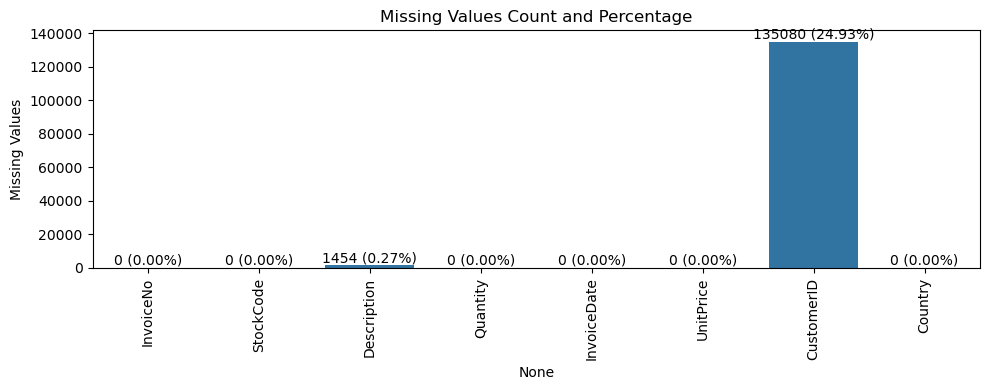

In [38]:
plt.figure(figsize=(10, 4))

# Calculate missing values and their percentage
missing_values = df.isna().sum()
missing_percentage = (missing_values / len(df)) * 100

# Combine both counts and percentages into a single dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# Plot the missing values count and percentage
sns.barplot(x=missing_data.index, y=missing_data['Missing Values'], orient='v')
plt.title('Missing Values Count and Percentage')
plt.xticks(rotation=90)

# Annotate each bar with the count and percentage
for i in range(missing_data.shape[0]):
    plt.text(i, missing_data['Missing Values'][i], f'{missing_data["Missing Values"][i]} ({missing_data["Percentage"][i]:.2f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Investigate the null values further

In [ ]:
# Extract records with null CustomerID
df_null_customer_id = df[df['CustomerID'].isna()]

# Print the head of the new dataframe
df_null_customer_id.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


## Drop Missing Values

In [41]:
df = df.dropna(subset=['CustomerID'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


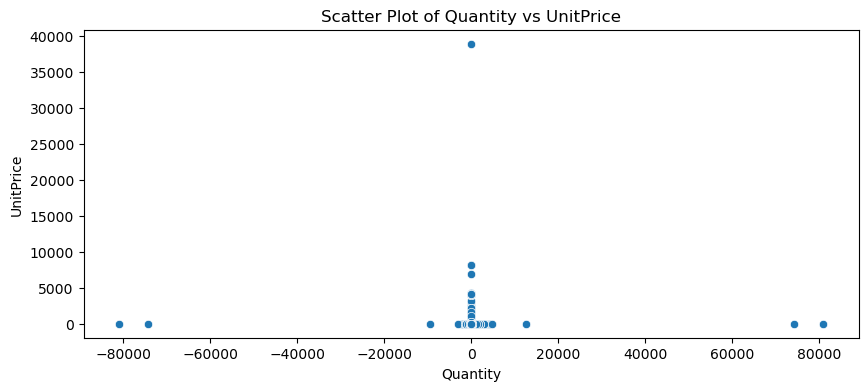

In [51]:
plt.figure(figsize=(10, 4))
sns.scatterplot(data=df, x='Quantity', y='UnitPrice')
plt.title('Scatter Plot of Quantity vs UnitPrice')
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')
plt.show()

In [ ]:
# Convert nominal fields to categorical data types
df['InvoiceNo'] = df['InvoiceNo'].astype('category')
df['StockCode'] = df['StockCode'].astype('category')
df['Description'] = df['Description'].astype('str')
df['Quantity'] = df['Quantity'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['UnitPrice'] = df['UnitPrice'].astype(float)
df['CustomerID'] = df['CustomerID'].astype(int).astype('category')
df['Country'] = df['Country'].astype('category')

# Display the first few rows of the dataframe to verify changes
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [54]:
df.value_counts('Country')

Country
United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   InvoiceNo    406829 non-null  category
 1   StockCode    406829 non-null  category
 2   Description  406829 non-null  object  
 3   Quantity     406829 non-null  int64   
 4   InvoiceDate  406829 non-null  object  
 5   UnitPrice    406829 non-null  float64 
 6   CustomerID   406829 non-null  category
 7   Country      406829 non-null  category
dtypes: category(4), float64(1), int64(1), object(2)
memory usage: 19.2+ MB
